### Agente con consultas a una Base de Datos

Definimos el LLM

In [333]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os

load_dotenv()
openai_model = os.getenv("LLM_MODEL", "gpt-o4-mini")

# Crear una instancia del modelo ChatOpenAI
llm = ChatOpenAI(model= openai_model, temperature=0.5)

Hacemos la conexion con la base de datos

In [334]:
from langchain_community.utilities import SQLDatabase

username = os.getenv("POSTGRES_USER")
password = os.getenv("POSTGRES_PASSWORD")
host = os.getenv("POSTGRES_HOST", "localhost")  # Default to localhost
port = os.getenv("POSTGRES_PORT", "5432")  # Default PostgreSQL port
database = os.getenv("POSTGRES_DB", "mydatabase")  # Default database name

print(f"Connecting to database {database} at {host}:{port} as user {username}")

connection_uri = f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}"

dbEngine = SQLDatabase.from_uri(connection_uri)
print(dbEngine.dialect)
print(dbEngine.get_usable_table_names())

Connecting to database product_marketing at localhost:5432 as user user
postgresql
['caracteristica', 'categoria', 'imagen', 'lista', 'oferta_articulo', 'precio', 'producto', 'promocion', 'tipo_caracteristica', 'variante']


Usamos las herramientas proveidas por SQLDatabaseToolkit para listar las tablas

In [335]:
from langchain_core.tools import tool
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langgraph.prebuilt import ToolNode
from langchain_core.messages import ToolMessage

toolkit = SQLDatabaseToolkit(db=dbEngine, llm=llm)
tools = toolkit.get_tools()

get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")

def list_tables():
    """List all tables in the database."""
    return dbEngine.get_usable_table_names()

def get_schema():
    """Get the schema of the database."""
    
    return dbEngine.get_table_info()
    

list_tables_result = list_tables()
tables_schema = get_schema()

print(list_tables_result)
print(tables_schema)

['caracteristica', 'categoria', 'imagen', 'lista', 'oferta_articulo', 'precio', 'producto', 'promocion', 'tipo_caracteristica', 'variante']

CREATE TABLE caracteristica (
	id UUID NOT NULL, 
	variante_id UUID, 
	tipo_id UUID, 
	valor VARCHAR NOT NULL, 
	CONSTRAINT caracteristica_pkey PRIMARY KEY (id), 
	CONSTRAINT caracteristica_tipo_id_fkey FOREIGN KEY(tipo_id) REFERENCES tipo_caracteristica (id), 
	CONSTRAINT caracteristica_variante_id_fkey FOREIGN KEY(variante_id) REFERENCES variante (id)
)

/*
3 rows from caracteristica table:
id	variante_id	tipo_id	valor
0b3265ac-4c7e-4dd8-95c8-83d3fcc3ddcb	2c75be55-d915-4d84-b7a9-0fb623c9823b	62cdd8eb-40ce-4f85-ba23-6f511fe8101f	16
ad199134-30ab-4283-9caf-103975595982	34572516-442c-4912-9be6-12b206955867	62cdd8eb-40ce-4f85-ba23-6f511fe8101f	32
11e3acf2-ee00-4a68-8000-da1fcf796860	73b3ab11-8fa4-4454-98ab-a4690f8a6b69	343d0a57-166f-45d0-8dd4-8d47b8e7f74b	White
*/


CREATE TABLE categoria (
	id UUID NOT NULL, 
	nombre VARCHAR NOT NULL, 
	CONSTRAINT 

Definimos el estado el cual será mutado por los nodos

In [336]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, AnyMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    """State of the agent."""
    last_question: str
    last_query: str
    last_query_result: str 
    
    summary: str
    messages: Annotated[Sequence[BaseMessage], add_messages]

Definimos la herramienta Query a BD

In [337]:
from langchain_core.messages import  SystemMessage, AIMessage, FunctionMessage, HumanMessage, RemoveMessage
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

@tool(return_direct=True)
def query_call ():
    """Just a call to the query tool."""
    
tools = [query_call]

Definimos los Nodos

In [ ]:
def needs_reformulation(current_question, last_question):
    # If the current question is a greeting or generic, treat as new topic
    generic_starts = ["ofreces", "ofrece", "ofrecen" , "puedes mostrarme", "hola", "buenos dias", "productos", "cosas", "promociones", "articulos"]
    if any(current_question.lower().startswith(g) for g in generic_starts):
        return False
    # If the current question is a follow-up (e.g., starts with "y", "además", etc.), reformulate
    follow_ups = ["y", "además", "con", "sin", "de", "otra vez", "opciones", "variantes", "caracteristicas", "precio", "promocion"]
    if any(current_question.lower().startswith(f) for f in follow_ups):
        return True
    # If the last question is empty, don't reformulate
    if not last_question:
        return False
    # Default: reformulate
    return True


def agent(state: AgentState):
    """
    El agente determina si se necesita usar la herramienta de query o responde con la info actual.
    Construye una lista de mensajes para el LLM en vez de un solo prompt.
    """
    messages = []
    question = state.get("messages")[-1].content
    last_question = state.get("last_question", "")
    last_query_result = state.get("last_query_result", "")
    last_query = state.get("last_query", "")

    # Mensaje de sistema base
    base_sys_msg = (
        "Eres un agente de marketing especializado en ofrecer productos y responder preguntas sobre estos. "
        "Cuentas con una herramienta que te permite consultar a la base de datos de productos para responder preguntas del cliente. "
        "Se te presentará con una pregunta la cual debes llamar a la herramienta en caso que el usuario pida "
        "Información sobre productos, variantes, características, categorías o precios de estos. "
        "En caso que la pregunta sea una confirmacion o sea evidente que falte contexto usa la herramienta. "
        "En caso que la pregunta no sea sobre productos, promociones, precios o caracteristicas , responde brevemente sin usar la herramienta. "
        "En caso que sí se necesita usar la herramienta, no pidas autorización al usuario, simplemente llama a la herramienta de consulta."
    )
    messages.append(SystemMessage(content=base_sys_msg))

    # Si hay resultado de query previo, añade contexto relevante
    if last_question:
        messages.append(SystemMessage(content="Usa la respuesta del query anterior y el resumen actual para responder si es posible."))
        messages.append(SystemMessage(content=f"Pregunta anterior: {last_question}"))
        messages.append(SystemMessage(content=f"Anterior query: {last_query}"))
        messages.append(SystemMessage(content=f"Resultado del query: {last_query_result}"))
        messages.append(SystemMessage(content="Si el sql query anterior no cubrió la pregunta del usuario, usa la herramienta para hacer un nuevo query."))
    else:
        messages.append(SystemMessage(content="Si necesitas información para la pregunta usa la herramienta."))

    # Añade la pregunta del usuario
    messages.append(HumanMessage(content=question))

    model = llm.bind_tools(tools)
    response = model.invoke(messages)

    return {"messages": [response]}


def reformulate_question(state: AgentState):
    """
    Antes de generar un query, se reformula la pregunta del usuario en base a la anterior pregunta, resumen y query.
    aqui se guarda la pregunta como ultima pregunta
    """
    messages = state.get("messages", [])
    
    last_question = state.get("last_question", "")
    last_query = state.get("last_query", "")
    last_response = messages[-4].content if messages else ""
    current_question = messages[-3].content if messages else ""
    summary = state.get("summary", "")
    
    if not needs_reformulation(current_question, last_question):
        return {"last_question": current_question, "messages": [HumanMessage(content=current_question)]}

    # Build message list for LLM: last question, last response, last query
    reformulation_messages = []
    if last_question:
        reformulation_messages.append(HumanMessage(content=f"Pregunta anterior: {last_question}"))
    if last_response:
        reformulation_messages.append(AIMessage(content=f"Respuesta anterior: {last_response}"))
    if last_query:
        reformulation_messages.append(SystemMessage(content=f"Query anterior: {last_query}"))

    # If not enough recent context, add summary
    if len(reformulation_messages) < 2 and summary:
        reformulation_messages.append(SystemMessage(content=f"Resumen de la conversación: {summary}"))

    prompt = (
        "Reformula la siguiente pregunta del usuario de manera breve,concisa y sin acentos para consultar a nuestra base de datos de productos "
        "dando prioridad al contexto reciente (pregunta, respuesta y query previos). "
        "No tomar en cuenta la respuesta anterior si no es relevante para la pregunta actual. "
        "Si no hay suficiente contexto reciente, usa el resumen."
    )
    reformulation_messages.append(SystemMessage(content=prompt))
    
    reformulation_messages.append(HumanMessage(content=current_question))
    reformulated = llm.invoke(reformulation_messages)
        
    return {"last_question": reformulated.content ,"messages": [reformulated]}

class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def generate_query(state: AgentState):
    """" Genera un query SQL a partir de una pregunta del usuario y el schema de la base de datos. """
    question = state.get("last_question", "")
    
    schema_message = SystemMessage(content=tables_schema)
    generate_query_system_prompt = f"""
    Dada las tablas de la base de datos, solo usa las disponibles.
    Se proveera una pregunta de entrada, crea una consulta {dbEngine.dialect} sintácticamente correcta para ayudar a encontrar la respuesta. 
    Puedes ordenar los resultados por una columna relevante para devolver los ejemplos más interesantes de la base de datos.

    En caso de consulta por caracteristicas de un producto, devuelve el nombre del producto con sus variantes y sus variantes con caracteristicas y precios.
    En caso que se consulte por promociones, devuelve la promocion con fechas y las variantes de productos relacionados con la tabla intermedia ProductoPromocion y la relacion con Promocion.
    Cuando hagas query por el preocio solo pide el precio "precio consumidor" a menos que se especifique lo contrario.

    Nunca consultes todas las columnas de una tabla específica, solo solicita las columnas relevantes según la pregunta.
    Presta atención a usar solo los nombres de columnas que aparecen en la descripción del esquema.
    Ten cuidado de no consultar columnas que no existen. Además, asegúrate de saber qué columna pertenece a qué tabla.
    """
    sys_message = SystemMessage(content=generate_query_system_prompt)
    
    question_message = HumanMessage(content=question)
    prompt_messages = [schema_message, sys_message, question_message]
    
    structured_llm = llm.with_structured_output(QueryOutput)
    response = structured_llm.invoke(prompt_messages)
    
    query = response.get("query", "")
    query_message = AIMessage(content=query)
    return {"last_query": query, "messages": [query_message]}

def run_query(state: AgentState):
    """Execute SQL query."""
    messages = state.get("messages", [])
    query = state.get("last_query", "")
    
    execute_query_tool = QuerySQLDatabaseTool(db=dbEngine)

    result = execute_query_tool.invoke(query)
    result_message = FunctionMessage(name="Sql_query", content=result)
    return {"last_query_result": result, "messages": [result_message]}

def generate_response(state: AgentState):
    """Generate a response based on the last query result and the summary."""
    question = state.get("last_question", "")
    last_query_result = state.get("last_query_result", "")
    
    prompt_message_list = []
    
    if(last_query_result):
        prompt_message_list.append(FunctionMessage(content=last_query_result, name="Sql_query"))
        prompt = """Actua como agente de marketing, usa unicamente el resultado de query para responder la pregunta:"""
    else:
        prompt = """No se obtuvo un resultado de query, responde a la pregunta unicamente ofreciendo realizar otra busqueda con diferentes valores del parametro consultado o generalizar la busqueda."""
    
    prompt_message_list.append(SystemMessage(content=prompt)) 
    prompt_message_list.append(HumanMessage(content=question))
    
    response = llm.invoke(prompt_message_list)
    
    return {"messages": [response]}

def summarize(state: AgentState):
    """Summarize the conversation."""
    messages = state.get("messages", [])
    summary = state.get("summary", "")
    
    if summary:
        prompt = f"Este es el resumen actual de la conversación:\n{summary}\n\nExpande el resumen incluyendo los puntos clave y las preguntas realizadas en 3 oraciones, sin incluir respuestas o resultados de consultas SQL."
    else: 
        prompt = "Resume la conversación pasada de manera concisa y clara, incluyendo los puntos clave y las preguntas realizadas en 3 oraciones, sin incluir respuestas o resultados de consultas SQL."
        
    summary_message = HumanMessage(content=prompt)    
    summary_response = llm.invoke(messages + [summary_message]) # type: ignore
    new_summary = summary_response.content
    
    delete_messages = [RemoveMessage(id=m.id) for m in messages][:-1]
    
    return {"summary": new_summary, "messages": delete_messages}

Hacemos una arista condicional

In [339]:
from langgraph.graph import END
from typing import Literal

max_messages_before_summary = 10

def summarize_condition(state: AgentState) -> Literal["summarize", END]:
    messages = state.get("messages", [])
    if len(messages) > max_messages_before_summary:
        return "summarize"
    return END

Checkpointer en sqlite

In [340]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
from pathlib import Path

base_dir = Path.cwd().parent
db_path = base_dir / "Databases/checkpoints.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)

Construimos el grafo

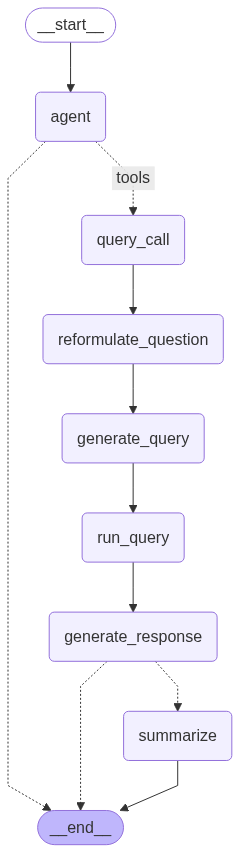

In [341]:
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition

query_call_node = ToolNode([query_call])

builder = StateGraph(AgentState)

builder.add_node("agent", agent)
builder.add_node("query_call", query_call_node)
builder.add_node("reformulate_question", reformulate_question)
builder.add_node("generate_query", generate_query)
builder.add_node("run_query", run_query)
builder.add_node("generate_response", generate_response)
builder.add_node("summarize", summarize)

builder.add_edge(START, "agent")
builder.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "query_call",
        END: END
    }
)
builder.add_edge("query_call", "reformulate_question")
builder.add_edge("reformulate_question", "generate_query")
builder.add_edge("generate_query", "run_query")
builder.add_edge("run_query", "generate_response")
builder.add_conditional_edges(
    "generate_response",
    summarize_condition,
    {
        "summarize": "summarize",
        END: END
    }
)
builder.add_edge("summarize", END)

agent = builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

Pruebas

In [342]:
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from uuid import uuid4

thread_id = str(uuid4())
config = RunnableConfig(configurable={"thread_id": thread_id})

print(f"----NUEVA CONVERSACION CREADA CON ID: {thread_id} ----")
pregunta = HumanMessage(content="Buenos dias")

for step in agent.stream(
    {
        "messages": [pregunta],
    },
    config= config
): 
    for node, update in step.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n")


----NUEVA CONVERSACION CREADA CON ID: c628a7da-f034-4210-8603-2d926315f6e2 ----
Update from node agent
================================== Ai Message ==================================

¡Buenos días! ¿En qué puedo ayudarte hoy?




otro mensaje

In [344]:
config = RunnableConfig(configurable={"thread_id": thread_id})
pregunta = HumanMessage(content="cuales son las caracteristicas de la laptop de 16 de ram?")

for step in agent.stream(
    {
        "messages": [pregunta],
    },
    config= config
): 
    for node, update in step.items():
        print("Update from node", node)
        if len(update["messages"]) > 0:
            update["messages"][-1].pretty_print()
        print("\n")

Update from node agent
================================== Ai Message ==================================
Tool Calls:
  query_call (call_tOwkDk4LwdCKk9ONPeLMLRLW)
 Call ID: call_tOwkDk4LwdCKk9ONPeLMLRLW
  Args:


Update from node query_call
================================= Tool Message =================================
Name: query_call

null


Update from node reformulate_question
================================== Ai Message ==================================

cuales son las caracteristicas de la laptop con 16GB de RAM?


Update from node generate_query
================================== Ai Message ==================================

SELECT p.nombre AS producto_nombre, v.descripcion AS variante_descripcion, c.valor AS caracteristica_valor, tc.nombre AS tipo_caracteristica_nombre, pr.precio
FROM producto p
JOIN variante v ON p.id = v.producto_id
JOIN caracteristica c ON v.id = c.variante_id
JOIN tipo_caracteristica tc ON c.tipo_id = tc.id
JOIN precio pr ON v.id = pr.variante_id
WHERE p.

Capturar penultimo mensaje

In [ ]:
config = RunnableConfig(configurable={"thread_id": thread_id})
pregunta = HumanMessage(content="cuales son las caracteristicas de la laptop de 16 de ram?")

for step in agent.stream(
    {
        "messages": [pregunta],
    },
    config= config
): 
    for node, update in step.items():
        print("Update from node", node)
        if len(update["messages"]) > 0:
            update["messages"][-1].pretty_print()
        print("\n")